<a href="https://colab.research.google.com/github/alirezasakhaei/RL_Course2023_Homeworks/blob/main/HW01/6_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations and Imports

In [ ]:
!sudo apt-get update
!pip install 'imageio==2.4.0'
!sudo apt-get install -y xvfb ffmpeg
!pip3 install gymnasium[classic_control]

In [2]:
import math
import base64
import random
import imageio
import IPython
import matplotlib
import gymnasium as gym
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utility functions for rendering evironment

In [3]:
def embed_mp4(filename):
  
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [4]:
def create_policy_eval_video(env, policy, filename, num_episodes=1, fps=30):
  
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
                action = policy(state)
                state, reward, terminated, truncated, _ = env.step(action.item())
                video.append_data(env.render())
                if terminated:
                    break
    return embed_mp4(filename)

# Replay Memory and Q-Network

In [7]:
SASR = namedtuple('SARS', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# Complete the Q-Network below. 
# The Q-Network takes a state as input and the output is a vector so that each element is the q-value for an action.
from torch.nn import functional as F
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # ==================================== Your Code (Begin) ==================================
        self.lin0 = nn.Linear(n_observations, 128)
        self.lin1 = nn.Linear(128, 128)
        self.lin2 = nn.Linear(128, n_actions)
        # ==================================== Your Code (End) ====================================

    def forward(self, x):
        # ==================================== Your Code (Begin) ==================================
        x = F.relu(self.lin0(x))
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        # ==================================== Your Code (End) ====================================

# Policies

Now we define 2 policies. We use greedy policy for evaluation and e-greedy during training.

In [8]:
# This function takes in a state and returns the best action according to your q-network.
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network. 
# state shape: (1, state_size) -> output shape: (1, 1)  
def greedy_policy(qnet, state):
    # ==================================== Your Code (Begin) ==================================
    if type(state) != type(torch.tensor([])):
        state = torch.tensor(state)
    state = state.to(DEVICE)
    with torch.no_grad():
        output = qnet(state)
    
    # if len(state.shape) > 1:
    #     dim = 1
    # else:
    #     dim = 0
    best = output.argmax().view(-1, 1)
    return best
    # ==================================== Your Code (End) ====================================

In [9]:
# state shape: (1, state_size) -> output shape: (1, 1)
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network.
def e_greedy_policy(qnet, state, current_timestep):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * current_timestep / EPS_DECAY)
    
    # ==================================== Your Code (Begin) ====================================
    # With probability "eps_threshold" choose a random action 
    # and with probability 1-"eps_threshold" choose the best action according to your Q-Network.
    current_timestep += 1
    rand = np.random.random()
    best_action = greedy_policy(qnet, state)
    if rand > eps_threshold:
        return best_action
    else:
        return torch.tensor(env.action_space.sample(), dtype=torch.long, device=DEVICE).view(-1, 1)
    # ==================================== Your Code (End) ====================================

# Initial setup

In [36]:
BATCH_SIZE = 128
GAMMA = 0.99 
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
MIN_MEMORY = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode='rgb_array')
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
q_network = DQN(n_observations, n_actions).to(device)
target_network = DQN(n_observations, n_actions).to(device)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.AdamW(q_network.parameters(), lr=LR)
memory = ReplayMemory(10000)

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s)[0][0], "random_agent")

# Training

In [35]:
def is_not_none(x):
    return x is not None

def calc_vals():
    samples = memory.sample(BATCH_SIZE)
    batch = SASR(*zip(*samples))
    mask = torch.tensor(tuple(map(is_not_none, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([ns for ns in batch.next_state if is_not_none(ns)])
    states_batch = torch.cat(batch.state)
    actions_batch = torch.cat(batch.action)
    rewards_batch = torch.cat(batch.reward)

    old_vals = q_network(states_batch).gather(1, actions_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[mask] = target_network(non_final_next_states).max(1)[0]
    new_vals = (next_state_values * GAMMA) + rewards_batch

    return old_vals, new_vals

def optimize_model():
    if len(memory) < MIN_MEMORY:
        return

    old_vals, new_vals = calc_vals()
    # optimization step
    # loss_fn = nn.SmoothL1Loss()
    loss_fn = nn.MSELoss()
    loss = loss_fn(old_vals, new_vals.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(q_network.parameters(), 100)
    optimizer.step()

100%|██████████| 600/600 [12:29<00:00,  1.25s/it]

Complete


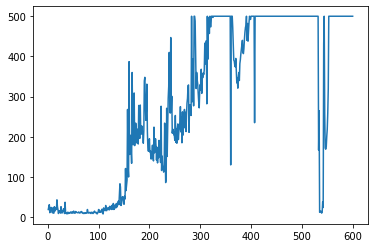

In [37]:
num_episodes = 600
episode_returns = []
episode_durations = []
time_step = 0   
for i_episode in tqdm(range(num_episodes)):
    # ==================================== Your Code (Begin) ====================================
    # 1. Start a new episode
    episode_returns.append(0)
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    i = 0
    done = False
    while not done:
        
        # 2. Run the environment for 1 step using e-greedy policy
        action = e_greedy_policy(q_network, state, time_step)
        time_step += 1
        obv, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
 
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(obv, dtype=torch.float32, device=device).unsqueeze(0)
        reward = torch.tensor([reward], device=device)
        # 3. Add the (state, action, next_state, reward) to replay memory
        
        memory.push(SASR(state, action, next_state, reward))
        state = next_state
        # 4. Optimize your q_network for 1 iteration
        optimize_model()
        # 5. Soft update the weights of target_network
        theta_prime = target_network.state_dict()
        theta = q_network.state_dict()
        for key in theta:
            theta_prime[key] = TAU*theta[key] + (1-TAU)*theta_prime[key]
        target_network.load_state_dict(theta_prime)           
        # 6. Keep track of the total reward for each episode to plot later
        episode_returns[i_episode] += (GAMMA**i) * reward.item()
        i += 1

        # Loop Break
        if done:
            episode_durations.append(i)

    # ==================================== Your Code (End) ====================================  

print('Complete')
plt.plot(range(1, num_episodes+1), episode_durations)

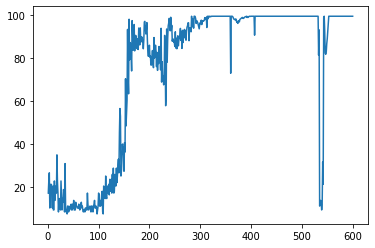

In [39]:
plt.plot(range(1, num_episodes+1), episode_returns)

In [38]:
# Render trained model

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s)[0][0], "trained_agent")